In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader


from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os
from os.path import join
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from sklearn.metrics import confusion_matrix


from dataset import XtoCDataset
from training import load_data, load_attributes, load_classes, dataset_loader, ConceptModel

c:\Users\Simon\OneDrive\DTU\10.sem\Responsible AI\XAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# static setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# path setup
ROOT_DIR = os.getcwd()
OUT_DIR = join(ROOT_DIR, 'output')
# DATA_DIR = join(ROOT_DIR, 'data')
CUB_DIR = join(ROOT_DIR, 'CUB_200_2011')
print(f'Root dir: \t"{ROOT_DIR}"\nOutput dir: \t"{OUT_DIR}"\nCUB dir: \t"{CUB_DIR}"')

Root dir: 	"c:\Users\Simon\OneDrive\DTU\10.sem\Responsible AI\XAI"
Output dir: 	"c:\Users\Simon\OneDrive\DTU\10.sem\Responsible AI\XAI\output"
CUB dir: 	"c:\Users\Simon\OneDrive\DTU\10.sem\Responsible AI\XAI\CUB_200_2011"


### Load images
We trained on classes 001 to 005, so we choose one bird for each class from the testset to evaluate some saliency maps for explanability of the concept model's decisions.

In [3]:
# image load
trainset, testset = load_data(ROOT_DIR)
attributes = load_attributes(CUB_DIR)
classes = load_classes(CUB_DIR)

idx = 10

train_dataset = dataset_loader(trainset[idx:idx+1]) # transforms as well
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)


allowed_classes = [0, 1, 2, 3, 4]
lucky_birds = []
bird_counter = 0
for bird in testset:
    if bird_counter > 4:
        break
    elif bird['class_label'] == bird_counter:
        lucky_birds.append(bird)
        bird_counter += 1

[print(f'Bird ID: {bird["id"]}, \tspecies: {classes[bird["class_label"]][4:]}') for bird in lucky_birds];
test_dataset = dataset_loader(lucky_birds) # transforms as well
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

Bird ID: 39, 	species: Black_footed_Albatross
Bird ID: 70, 	species: Laysan_Albatross
Bird ID: 175, 	species: Sooty_Albatross
Bird ID: 223, 	species: Groove_billed_Ani
Bird ID: 239, 	species: Crested_Auklet


### Examine saliency maps of the Independently trained concept model

In [4]:
concept_model = ConceptModel()

In [5]:
# load pretrained indepedent model # later load all 4 (3?) types of models
concept_model.eval()
concept_model.load_state_dict(torch.load(join(ROOT_DIR, 'models', 'seqc_model.pth')))

<All keys matched successfully>

In [6]:
with torch.no_grad():
    for img_batch, class_labels, attr_labels in test_loader:
        img_batch, class_labels = img_batch.to(device), class_labels.to(device)
        outputs = concept_model(img_batch)

In [7]:
#TODO: ! extend to multiple images...

ground_truth = torch.tensor(test_loader.dataset.attribute_labels[0])
predicted = outputs[0] > 0.1

# Generate the confusion matrix
cm = confusion_matrix(ground_truth, predicted)

print(cm)
# TN, FP
# FN, TP

# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)
precision = cm[1][1] / (cm[1][1] + cm[0][1])
recall = cm[1][1] / (cm[1][1] + cm[1][0])
f1 = 2 * (precision * recall) / (precision + recall)
print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1: {f1:.2f}')

[[228  59]
 [  6  19]]
Precision: 0.24
Recall: 0.76
F1: 0.37


In [8]:
# attributes correctly predicted for a single bird.
def get_correct_attributes(true_labels, predicted_labels, attributes, bird_id, threshold=0.1):
    gt = torch.tensor(true_labels[bird_id])
    pred = predicted_labels[bird_id] > threshold
    return [(i, attributes[i]) for i in range(len(ground_truth)) if gt[i] == 1 and pred[i] == 1]

get_correct_attributes(test_loader.dataset.attribute_labels, outputs, attributes, bird_id=1, threshold=0.1)

[(14, 'has_wing_color::grey'),
 (51, 'has_underparts_color::white'),
 (54, 'has_breast_pattern::solid'),
 (117, 'has_breast_color::white'),
 (132, 'has_throat_color::white'),
 (145, 'has_eye_color::black'),
 (149, 'has_bill_length::about_the_same_as_head'),
 (164, 'has_forehead_color::white'),
 (194, 'has_nape_color::white'),
 (209, 'has_belly_color::white'),
 (216, 'has_wing_shape::long-wings'),
 (220, 'has_size::medium_(9_-_16_in)'),
 (236, 'has_back_pattern::solid'),
 (240, 'has_tail_pattern::solid'),
 (244, 'has_belly_pattern::solid'),
 (253, 'has_primary_color::grey'),
 (260, 'has_primary_color::white'),
 (305, 'has_crown_color::white'),
 (311, 'has_wing_pattern::multi-colored')]

In [9]:
# img = train_loader.dataset.images[0]
# img = img.unsqueeze(0)
# layer_gradcam = LayerGradCam(concept_model, concept_model.model.Mixed_7a)
# attributions_lgc = layer_gradcam.attribute(img, target=151)

# upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, img.shape[2:], 'bilinear')

# print(attributions_lgc.shape)
# print(upsamp_attr_lgc.shape)
# print(img.shape)

# fig, ax = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
#                                       img[0].permute(1,2,0).numpy(),
#                                       ["original_image","blended_heat_map","masked_image"],
#                                       ["all","positive","positive"],
#                                       show_colorbar=True,
#                                       titles=["Original", "Positive Attribution", "Masked"],
#                                       fig_size=(18, 6))

In [10]:
# [print(f'ID: {bird["id"]}, {classes[bird["class_label"]][4:]}') for bird in lucky_birds];
[f'{classes[bird["class_label"]][4:]}' for bird in lucky_birds]

['Black_footed_Albatross',
 'Laysan_Albatross',
 'Sooty_Albatross',
 'Groove_billed_Ani',
 'Crested_Auklet']

In [52]:
get_correct_attributes(test_loader.dataset.attribute_labels, outputs, attributes, bird_id=1, threshold=0.3)

[(54, 'has_breast_pattern::solid'),
 (145, 'has_eye_color::black'),
 (149, 'has_bill_length::about_the_same_as_head'),
 (220, 'has_size::medium_(9_-_16_in)'),
 (236, 'has_back_pattern::solid'),
 (240, 'has_tail_pattern::solid'),
 (244, 'has_belly_pattern::solid')]

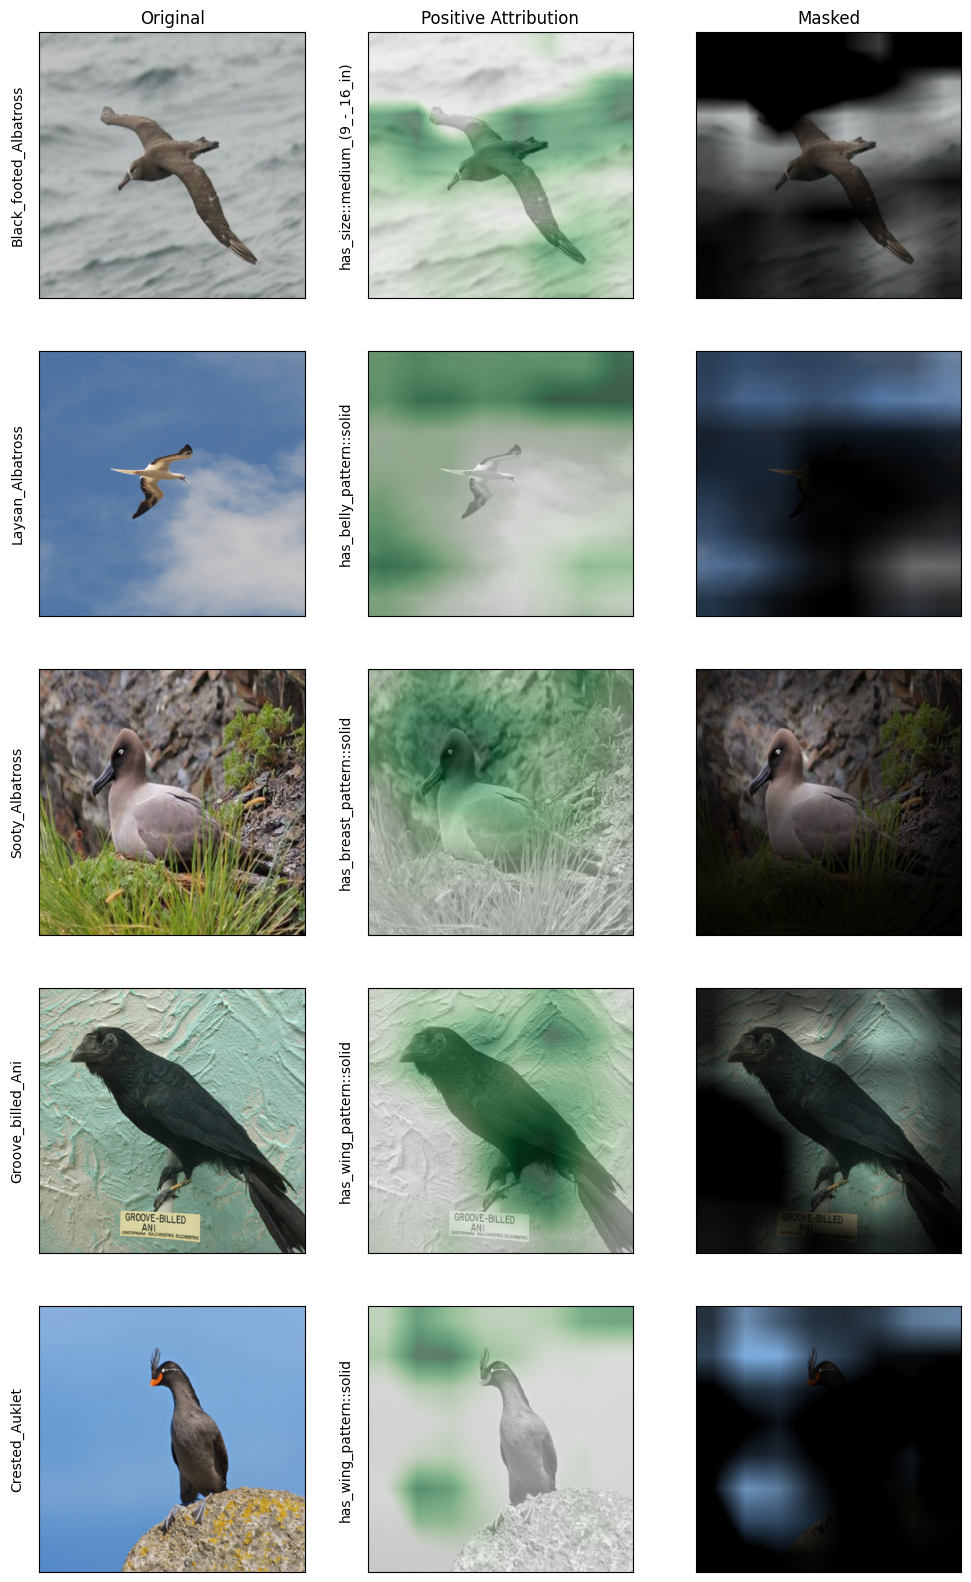

In [59]:
"""
change attr_targets to something that shows a well performing saliency map for each bird in attr_targets.
you can copy this and make saliency maps that show bad behavior as well.
check the function above that can show correct predicted concepts for a class/id of bird.

??? currently no way to change layer that constitutes the saliency map per bird.
??? might be nice make another type of saliency map, should be easy to extend this block.

If you want the grid transposed you have to switch where method_title and birds go in the code.
also flip the subplots shape, and likewise where the bird and m index go in plt_fig_axis. That should go a long way.
"""

methods = ["original_image", "blended_heat_map", "masked_image"]
signs = ["all", "positive", "positive"]
method_title = ["Original", "Positive Attribution", "Masked"]
birds = [f'{classes[bird["class_label"]][4:]}' for bird in lucky_birds]
attr_targets = [220, 244, 54, 308, 308]
attr_names = [attributes[i] for i in attr_targets]

layer_gradcam = LayerGradCam(concept_model, concept_model.model.Mixed_7c)


plt_fig, plt_axis = plt.subplots(len(test_loader.dataset), len(methods), figsize=(12, 20))

for bird in range(len(test_loader.dataset)):
    img = test_loader.dataset.images[bird].unsqueeze(0)
    attributions_lgc = layer_gradcam.attribute(img, target=attr_targets[bird])
    attr = LayerAttribution.interpolate(attributions_lgc, img.shape[2:], 'bilinear')
    
    for m in range(len(methods)):    
        viz.visualize_image_attr(
            attr.cpu().squeeze(0).permute(1,2,0).detach().numpy(),
            original_image=img.squeeze(0).permute(1,2,0).numpy(),
            method=methods[m],
            sign=signs[m],
            plt_fig_axis=(plt_fig, plt_axis[bird, m]),
            use_pyplot=False,
            title=method_title[m] if bird==0 else None,
        )

    plt_axis[bird, 0].set_ylabel(birds[bird], rotation=90)
    plt_axis[bird, 1].set_ylabel(attr_names[bird], rotation=90)